In [1]:
!pip install pandas scikit-learn matplotlib seaborn black

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
path = "data/BYAGE.txt"
op_path = "data/byage_processed.csv"

# Open the text file for reading
with open(path, "r") as file:
    # Read the contents of the file
    file_content = file.read()

# Replace " with empty string
file_content = file_content.replace('"', '')

# Write the modified content to a CSV file
with open(op_path, "w") as csv_file:
    csv_file.write(file_content)

### Create utility functions

In [4]:
# Define a function to extract the maximum value from each age range
def extract_max_age(age_range):
    if '-' in age_range:
        return int(age_range.split('-')[-1])
    elif '+' in age_range:
        return int(age_range[:-1])
    elif '<' in age_range:
        return 1
    else:
        return int(age_range)

def get_raw_dataframe():
	# Load the dataset
	v_dtype = {
		'AGE': str, 
		'CI_LOWER': float, 
		'CI_UPPER': float, 
		'COUNT': int, 
		'EVENT_TYPE': str, 
		'POPULATION': int, 
		'RACE': str, 
		'RATE': float, 
		'SEX': str, 
		'SITE': str, 
		'YEAR': int
		}
	v_cols = {
		'AGE': 'Age', 
		'CI_LOWER': 'ci_lower', 
		'CI_UPPER': 'ci_upper', 
		'COUNT': 'count', 
		'EVENT_TYPE': 'event_type', 
		'POPULATION': 'population', 
		'RACE': 'race', 
		'RATE': 'rate', 
		'SEX': 'sex', 
		'SITE': 'site', 
		'YEAR': 'year'
		}
	main_df = pd.read_csv(op_path, header=1, delimiter='|', dtype=v_dtype, low_memory=False)

	df = pd.read_csv(op_path, header=1, delimiter='|', dtype=v_dtype, low_memory=False)
	main_df.columns = v_cols
	df.columns = v_cols
     	
	# Apply the function to the 'AGE' column to create a new numeric column
	df['AGE'] = df['AGE'].apply(extract_max_age)
	return df

def get_eda_dataframe(is_low_rate: bool = True):
     # Load the dataset
     eda_df = get_raw_dataframe()
     eda_df = eda_df[eda_df['YEAR'] != '2016-2020']
     eda_df = eda_df[eda_df['RACE'] != 'All Races']
     eda_df = eda_df.drop(columns=['SITE', 'CI_LOWER', 'CI_UPPER', 'YEAR', 'POPULATION', 'COUNT'])
     eda_df['RATE'] = pd.to_numeric(eda_df['RATE'], errors='coerce')
     if is_low_rate:
          eda_df = eda_df[eda_df['RATE'] < 100]
     else:
          eda_df = eda_df[eda_df['RATE'] > 100]
     return eda_df

def get_clean_dataset():
     # Load the dataset
     df = get_raw_dataframe()

     df = df[df['YEAR'] != '2016-2020']
     df = df[df['RACE'] != 'All Races']
     df = df.drop(columns=['SITE', 'YEAR', 'POPULATION', 'COUNT'])
     df['RATE'] = pd.to_numeric(df['RATE'], errors='coerce')
     
     # Drop rows with missing values
     df.dropna(inplace=True)
     
     # Convert '~' to NaN
     df.replace('~', np.nan, inplace=True)
     
     # Convert '.' to NaN
     df.replace('.', np.nan, inplace=True)
     
     # Drop rows with NaN values
     df.dropna(inplace=True)
     
     # Convert columns to appropriate data types
     df['AGE'] = df['AGE'].astype(str)
     df['CI_LOWER'] = pd.to_numeric(df['CI_LOWER'], errors='coerce')
     df['CI_UPPER'] = pd.to_numeric(df['CI_UPPER'], errors='coerce')
     # df['COUNT'] = df['COUNT'].astype(int)
     df['EVENT_TYPE'] = df['EVENT_TYPE'].astype(str)
     # df['POPULATION'] = df['POPULATION'].astype(int)
     df['RACE'] = df['RACE'].astype(str)
     df['RATE'] = pd.to_numeric(df['RATE'], errors='coerce')
     df['SEX'] = df['SEX'].astype(str)
     # df['SITE'] = df['SITE'].astype(str)
     # df['YEAR'] = df['YEAR'].astype(int)
     
     return df

### Create a dataframe for EDA

### Implement Linear Regression and Check Coefficients

In [5]:
df = get_clean_dataset()

# Encode categorical variables if necessary
# For example, use one-hot encoding for the 'RACE' and 'SEX' columns as they are categorical
df = pd.get_dummies(df, columns=['RACE', 'SEX', 'EVENT_TYPE'])
# Feature Engineering (if necessary)

# Split the dataset into features (X) and target variable (y)
X = df.drop(columns=['RATE'])  # Features
y = df['RATE']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Selection
# Linear Regression
model = LinearRegression()

# Model Training
model.fit(X_train, y_train)

# Model Evaluation
# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Interpretation
# Coefficients of the linear regression model
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
coefficients.to_csv("data/coefficients.csv")
print("Coefficients:")
print(coefficients)


Mean Squared Error: 0.4956589981692807
Coefficients:
                                                 Coefficient
AGE                                                -0.002033
CI_LOWER                                            0.544500
CI_UPPER                                            0.457816
RACE_Hispanic of any race                           0.228447
RACE_Non-Hispanic American Indian/Alaska Native    -0.804804
RACE_Non-Hispanic Asian/Pacific Islander            0.180949
RACE_Non-Hispanic Black                             0.242335
RACE_Non-Hispanic White                             0.153073
SEX_Female                                          0.004887
SEX_Male                                           -0.030392
SEX_Male and Female                                 0.025505
EVENT_TYPE_Incidence                                0.010510
EVENT_TYPE_Mortality                               -0.010510


### Plot RACE coefficients

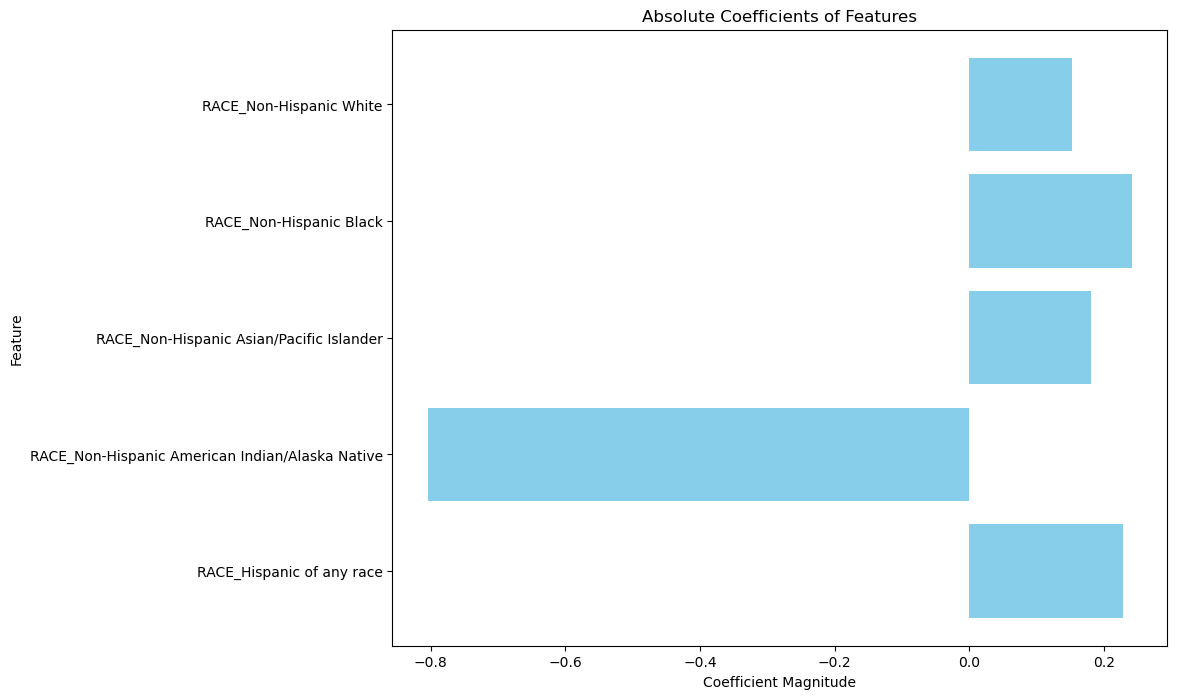

In [6]:
# Sort the coefficients DataFrame by absolute coefficient values
race_coefficients = coefficients[coefficients.index.str.startswith('RACE')]

# Plot the coefficients as a bar chart
plt.figure(figsize=(10, 8))
plt.barh(race_coefficients.index, race_coefficients['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Absolute Coefficients of Features')
plt.show()


### Plot SEX Coefficients

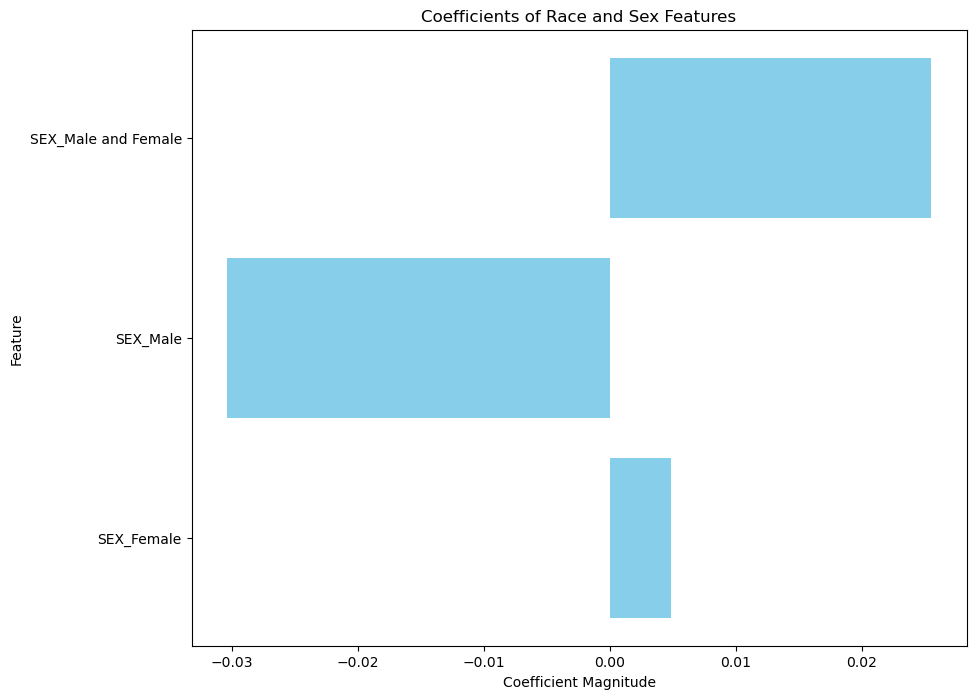

In [7]:
# Filter the coefficients DataFrame to include coefficients for both race and sex
race_sex_coefficients = coefficients[coefficients.index.str.startswith(('SEX'))]

# Plot the coefficients as a bar chart
plt.figure(figsize=(10, 8))
plt.barh(race_sex_coefficients.index, race_sex_coefficients['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Coefficients of Race and Sex Features')
plt.show()


c:\Users\jsnow\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jsnow\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jsnow\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


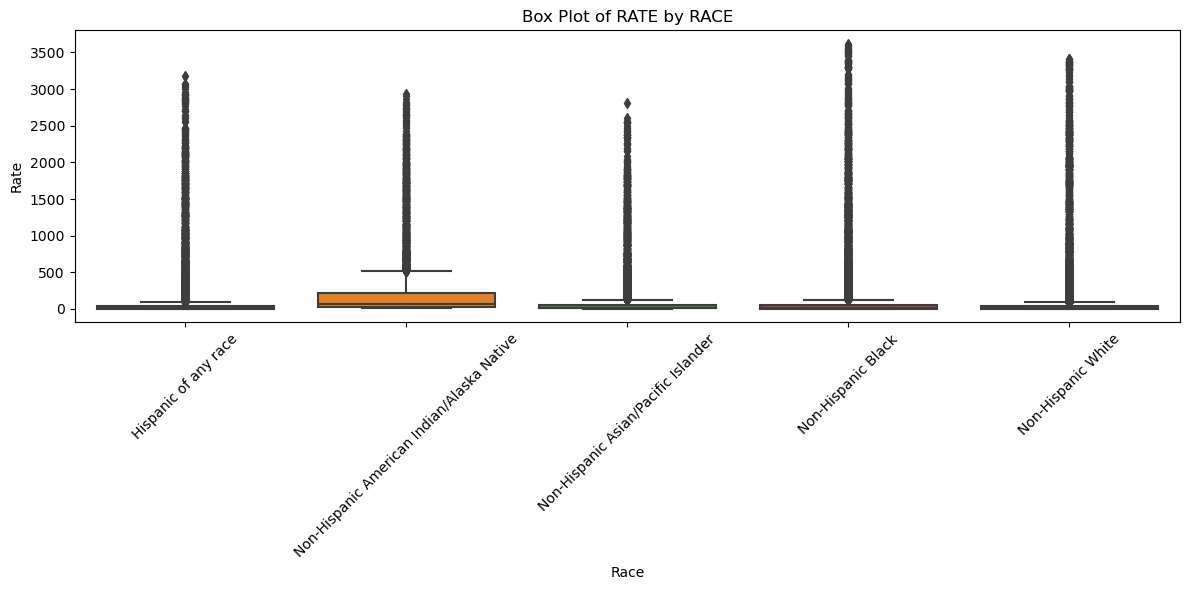

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

df = get_clean_dataset()
# Create a box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='RACE', y='RATE', data=df)
plt.title('Box Plot of RATE by RACE')
plt.xlabel('Race')
plt.ylabel('Rate')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


### exploratory visualization

Summary Statistics for Rate:
count    144098.000000
mean         86.357479
std         265.705278
min           0.100000
25%           3.900000
50%          15.700000
75%          51.400000
max        3620.900000
Name: RATE, dtype: float64


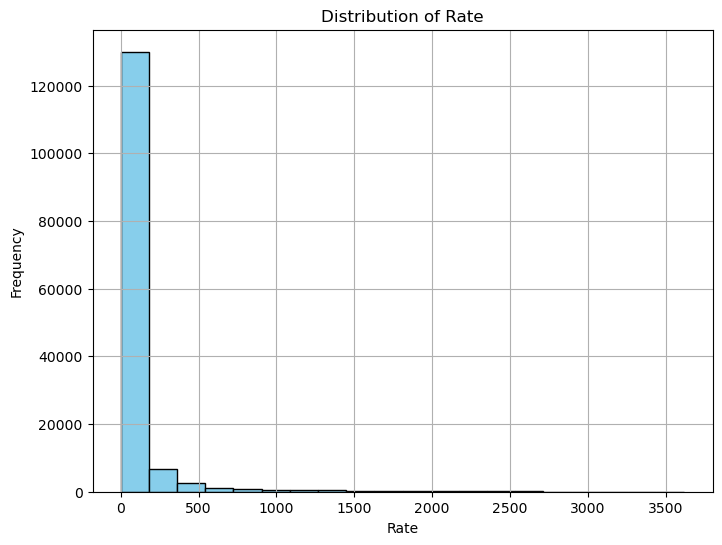

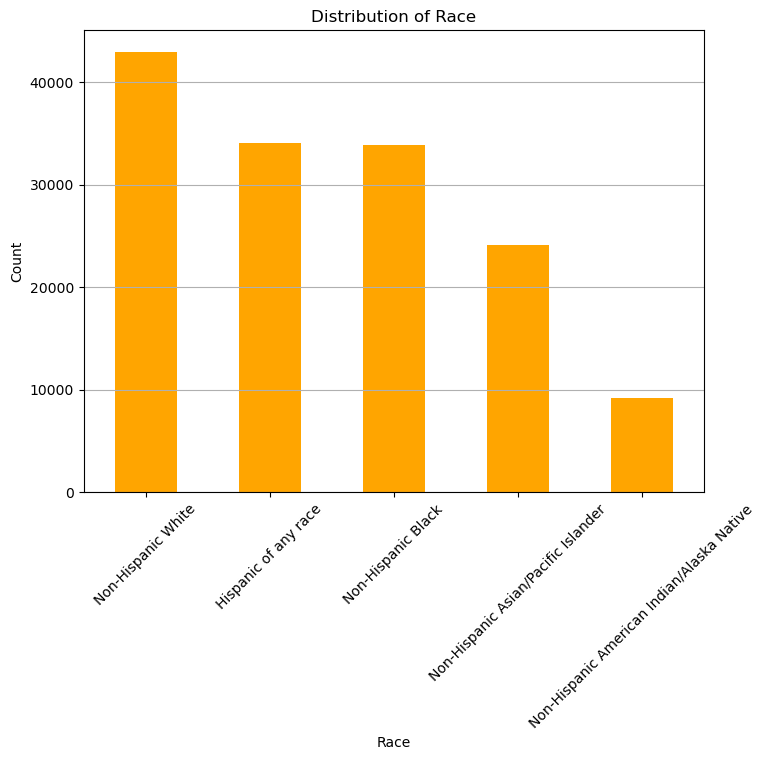

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing the data
df = get_clean_dataset()

# Summary Statistics for 'Rate'
rate_summary = df['RATE'].describe()
print("Summary Statistics for Rate:")
print(rate_summary)

# Histogram for 'Rate'
plt.figure(figsize=(8, 6))
plt.hist(df['RATE'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Rate')
plt.xlabel('Rate')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Bar Plot for 'RACE'
race_counts = df['RACE'].value_counts()
plt.figure(figsize=(8, 6))
race_counts.plot(kind='bar', color='orange')
plt.title('Distribution of Race')
plt.xlabel('Race')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


### Check RACE and RATE Corelation for RATE < 100

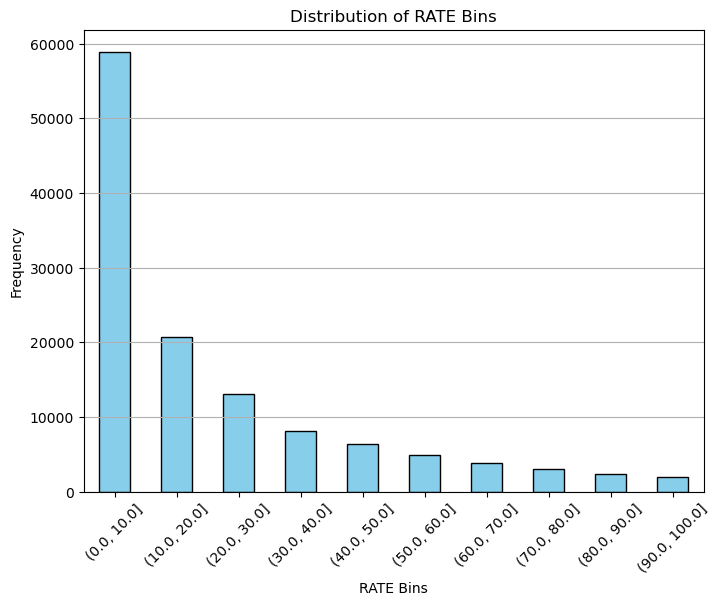

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = get_eda_dataframe()

# Define the bin edges
bin_edges = np.arange(0, df['RATE'].max() + 10, 10)  # Adjust the bin width as needed

# Create bins for the 'RATE' column
df['RATE_BIN'] = pd.cut(df['RATE'], bins=bin_edges)

# Plot histogram of the 'RATE' bins
plt.figure(figsize=(8, 6))
df['RATE_BIN'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of RATE Bins')
plt.xlabel('RATE Bins')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


C:\Users\jsnow\AppData\Local\Temp\ipykernel_23488\1260800820.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate_race_counts = df.groupby(['RATE_BIN', 'RACE']).size().unstack()


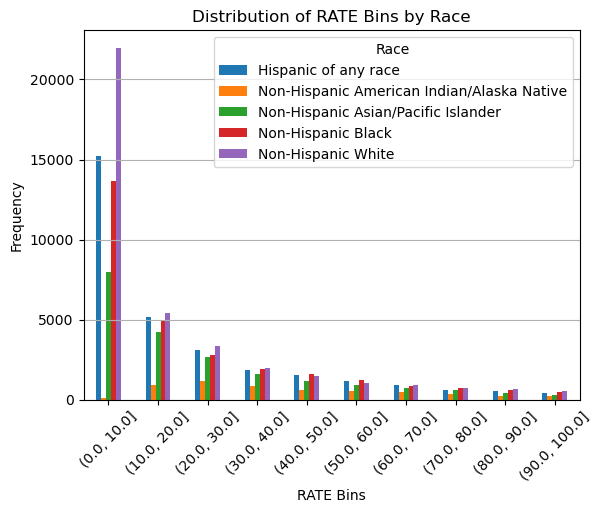

In [13]:
# Group by 'RATE_BIN' and 'RACE', then count the occurrences
rate_race_counts = df.groupby(['RATE_BIN', 'RACE']).size().unstack()

# Plotting the grouped bar plot
rate_race_counts.plot(kind='bar', stacked=False)
plt.title('Distribution of RATE Bins by Race')
plt.xlabel('RATE Bins')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend(title='Race')
plt.grid(axis='y')
plt.show()

### RATE more than 100

C:\Users\jsnow\AppData\Local\Temp\ipykernel_23488\1163078904.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate_race_counts = df.groupby(['RATE_BIN', 'RACE']).size().unstack()


<Figure size 1000x2000 with 0 Axes>

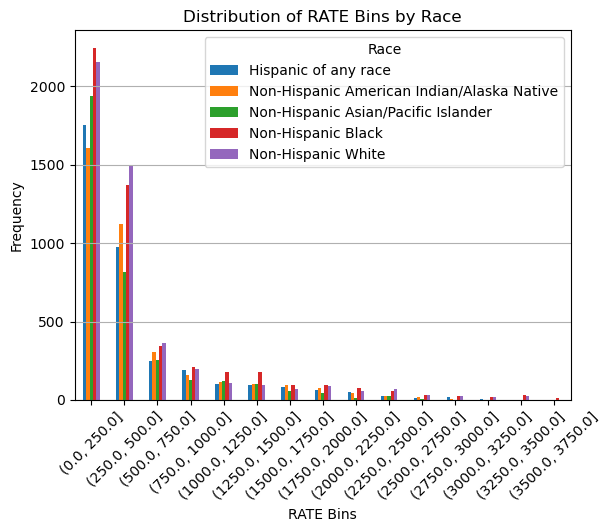

In [14]:
df = get_eda_dataframe(is_low_rate=False)

# Define the bin edges
bin_edges = np.arange(0, df['RATE'].max() + 250, 250)  # Adjust the bin width as needed

# Create bins for the 'RATE' column
df['RATE_BIN'] = pd.cut(df['RATE'], bins=bin_edges)

# Group by 'RATE_BIN' and 'RACE', then count the occurrences
rate_race_counts = df.groupby(['RATE_BIN', 'RACE']).size().unstack()

# Plotting the grouped bar plot
plt.figure(figsize=(10, 20))
rate_race_counts.plot(kind='bar', stacked=False)
plt.title('Distribution of RATE Bins by Race')
plt.xlabel('RATE Bins')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend(title='Race')
plt.grid(axis='y')
plt.show()